# Visualization and statistical analysis

Save the results as a 'destination folder/*-stats.csv' file

Define the result folder

In [1]:
import yaml
from pathlib import Path
from ipyfilechooser import FileChooser
srcdir, dstdir = '', ''
if Path("config.yml").exists():
    with open("config.yml", "r") as file:    
        config = yaml.safe_load(file)
        if 'source' in config.keys():
            srcdir = Path(config["source"])        
        if 'destination' in config.keys():
            dstdir = Path(config["destination"]) 

fc = FileChooser(dstdir, select_desc='Destination')
display(fc)

FileChooser(path='/home/jeromeb/work/code/octopus/results', filename='', title='', show_hidden=False, select_d…

In [2]:
import pandas as pd
dstdir = Path(fc.selected) if fc.selected is not None else Path(dstdir)
filelistname = dstdir / 'filelist.csv'
filelist = pd.read_csv(filelistname)
filelist

,folder,name,channel1,channel2,channel3,channel4
0,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnal...,vglut_B4_546,ppp1_B1_647,Th_B3_488,Nuclei
1,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnal...,tbh_B4_546,LGC007_B3_647,vacht_B2_488,Nuclei
2,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,2023_20Dec_2aBatch2_12Dec_F1_Stitched_Cropped_...,LGC041_B2_546,LGC046_B2_647,Th_B3_488,Nuclei
3,/media/cephfs/acourtney/HCR_Octopus_Jerome/Feb...,14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAna...,LGC009_B1_647,vglut_B4_546,Th_B3_488,Nuclei


In [3]:
from itertools import chain, combinations
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import napari

def get_files(dstdir, row, key=None):
    if key == 'ims':
        return Path(row['folder']) / row['name']
    elif key == 'regions':
        return Path(dstdir / str(row["name"]).replace('.ims','-regions.json'))
    elif key == 'labels':
        return Path(dstdir / str(row['name']).replace('.ims','-labels.tif'))
    elif key == 'measurements':
        return Path(dstdir / str(row['name']).replace('.ims','-measurements.csv'))
    elif key == 'stats':
        return Path(dstdir / str(row['name']).replace('.ims','-stats.csv'))
    else:
        return {
            'ims': get_files(dstdir, row, 'ims'),
            'regions': get_files(dstdir, row, 'regions'),
            'labels': get_files(dstdir, row, 'labels'),
            'measurements':  get_files(dstdir, row, 'measurements')
        }
    
def get_measurement_channels(df):
    """List the channels name from the measurement data"""
    return [c for k, c in enumerate(df.columns) if k > 5]    
    
def create_heatmaps(labels, df):    
    channel_columns = [f'c{k}' for k in range(10) if f'c{k}' in df.columns]

    heatmaps = np.zeros([len(channel_columns), *labels.shape])
    for row in df.iloc:
        for k, c in enumerate(channel_columns):
                heatmaps[k][labels == row['label']] = row[c]  
    return heatmaps

def madstd(x):
    """Median std"""
    return 1.48 * np.median(np.abs(x-np.median(x)))

def powerset(iterable):
    """Compute the powerset of iterable"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def encode(row, channels, thresholds, encoder):
    """compute a code from the channels columns and the tresholds"""
    t = tuple([c for c in channels if row[c] > thresholds[c]])
    return encoder[t]

def encode_channels(df, channels, thresholds):
    """Encode the channel in the data frame based on intensity (in place)
    
    Parameters
    ----------
    df : pd.DataFrame
    channels : List[str]
        list of channel names
    thresholds: List[float]
        list of threshold values
    
    Returns
    -------
    encoder decoder dicts
    """
    pset = [x for x in powerset(channels)]
    encoder = {x:k for k,x in enumerate(pset)}
    decoder = {k:x for k,x in enumerate(pset)}
    decoder[0] = ('none',)
    df['code id'] = df.apply(partial(encode, channels=channels, encoder=encoder, thresholds=thresholds), axis=1)
    decode_str = {a:b for a,b in enumerate(['+'.join([str(e) for e in k]) for k in encoder.keys()])}
    df['code str'] = [decode_str[k] for k in df['code id']]
    return encoder, decoder

def create_codemap(labels, df, decoder):
    """Create a map of the binary codes as a label map
    
    Note add 1 to the code so that it is not set to background
    """
    stack = np.zeros(labels.shape, dtype=np.uint8)
    for row in df.iloc:
        stack[labels == row['label']] = row['code id'] + 1        
    features = pd.DataFrame({'code':[ 'background', *[' + '.join(decoder[k]) for k in decoder ]]})
    return stack, features

def create_maps(labels, df, decoder):
    """Create a set of maps for each combination of labels"""
    nc = len(decoder)
    stack = np.zeros([nc, *labels.shape], dtype=np.uint8)
    for row in df.iloc:
        c = row['code id']        
        stack[c][labels == row['label']] = 255    
    names = [' + '.join(decoder[k]) for k in decoder ]
    return stack, names
    
def aggregate_combinations(input, decoder):
    """Aggregate the inputs based on combinations in the decoder
    
    Parameters
    ----------
    input: pd.DataFrame or np.array
        input on which to compute the aggregation
    decoder: dict
        mapping between keys of the input and the corresponding set of channels
    """
    output = input.copy()
    for k1 in decoder:        
        for k2 in decoder:            
            if len(decoder[k2]) > len(decoder[k1]):
                for y1 in decoder[k1]:
                    if y1 in decoder[k2]:
                        output[k1] = output[k1] + input[k2]
    return output


In [4]:
import ipywidgets as widgets
w = widgets.Dropdown(
    options=[(x,k) for k,x in enumerate(filelist['name'])],
    value=1,
    description='Image:'
)
display(w)

Dropdown(description='Image:', index=1, options=(('2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnalysis.ims', 0)…

Load the image

In [8]:
from imaris_ims_file_reader.ims import ims
row = filelist.iloc[w.value]
resolution_level = 1 # need to be the same than the one used for processing
img = ims(get_files(dstdir, row, 'ims'), ResolutionLevelLock=resolution_level)

Opening readonly file: /media/cephfs/acourtney/HCR_Octopus_Jerome/Febuary2024/test_15024/14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAnalysis.ims 

Closing file: /media/cephfs/acourtney/HCR_Octopus_Jerome/Febuary2024/test_15024/14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAnalysis.ims 



Add codes to the dataframe

In [9]:
labels = tifffile.imread(get_files(dstdir, row, 'labels'))

df = pd.read_csv(get_files(dstdir, row, 'measurements'), index_col=0)
df = pd.DataFrame(df.to_records())

channels = get_measurement_channels(df)

# compute the thresholds
thresholds = {c:df[c].median() + 0.5 * madstd(df[c]) for c in channels}            

for k,c in enumerate(channels):
    df[f'z{k}'] = (df[c] - df[c].median()) / madstd(df[c])

encoder, decoder = encode_channels(df, channels, thresholds)


Compute the label code map

In [10]:
codemaps, features = create_codemap(labels, df, decoder)

In [11]:
maps, names = create_maps(labels, df, decoder)

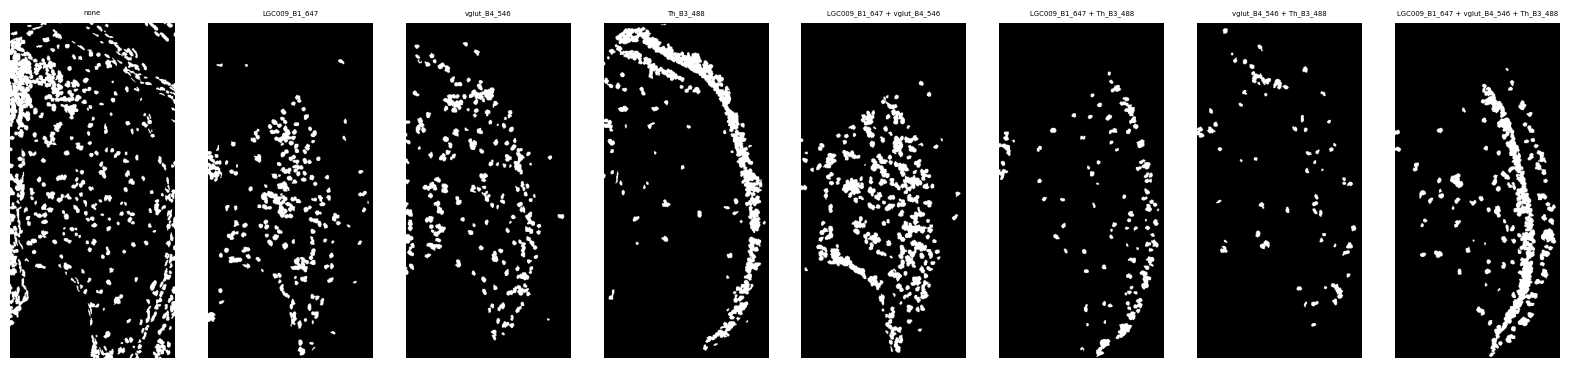

In [12]:
fig, ax = plt.subplots(1,len(names),figsize=(20,5))
for k in range(len(names)):         
    ax[k].imshow(np.amax(maps[k,:,::4,::4],0), cmap='gray')
    ax[k].set(title=names[k])
    ax[k].title.set_fontsize(5)
    ax[k].set_axis_off()


Compute aggregated maps

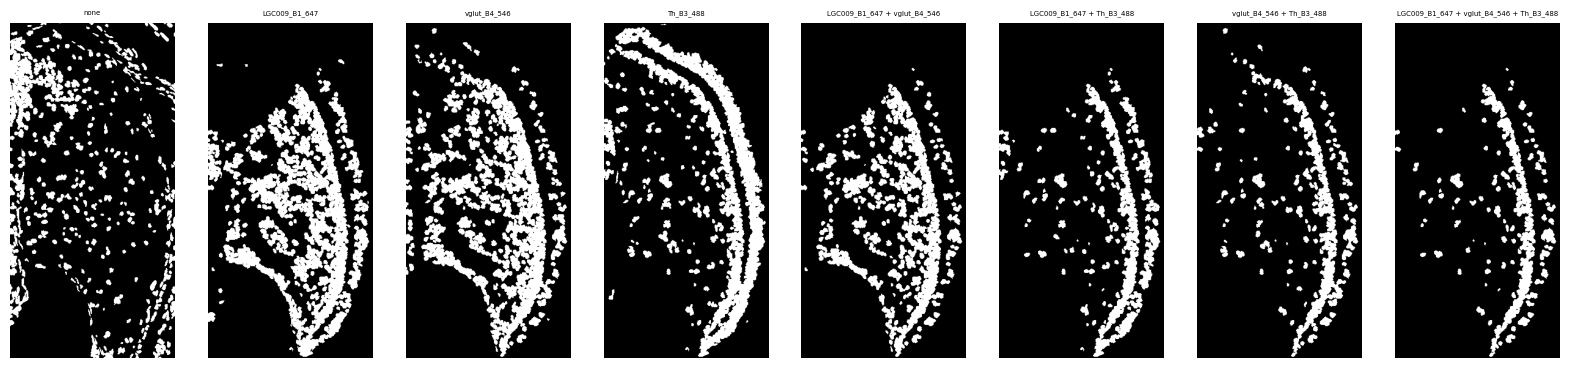

In [13]:
mapsagg = aggregate_combinations(maps, {k: tuple(c.split(' + ')) for k,c  in enumerate(names)} )
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,len(names),figsize=(20,5))
for k in range(len(names)):         
    ax[k].imshow(np.amax(mapsagg[k,:,::4,::4],0), cmap='gray')
    ax[k].set(title=names[k])
    ax[k].title.set_fontsize(5)
    ax[k].set_axis_off()

Visualize the result
- toggle the label layer to visualize the codes
- on the codemaps layer, tick the 'show selected' option and run through the labels to display the cells code by code

In [14]:
v = napari.view_image(img, channel_axis=1, name=[row[f'channel{k+1}'] for k in range(img.shape[1])])
v.add_labels(labels)
v.add_image(mapsagg,channel_axis=0,name=names)

[<Image layer 'none' at 0x7fd535800530>,
 <Image layer 'LGC009_B1_647 [1]' at 0x7fd5358013a0>,
 <Image layer 'vglut_B4_546 [1]' at 0x7fd5358d55b0>,
 <Image layer 'Th_B3_488 [1]' at 0x7fd5358f2720>,
 <Image layer 'LGC009_B1_647 + vglut_B4_546' at 0x7fd5357178f0>,
 <Image layer 'LGC009_B1_647 + Th_B3_488' at 0x7fd535996fc0>,
 <Image layer 'vglut_B4_546 + Th_B3_488' at 0x7fd535781940>,
 <Image layer 'LGC009_B1_647 + vglut_B4_546 + Th_B3_488' at 0x7fd5357a2e70>]

# Statistical analysis and figure
## Without aggregation by set labels
We first count the number of cell in each class and create a pivot table to visualize the results. Here the results are by class before aggregation of the sets.

In [15]:
tbl = pd.pivot_table(df.groupby(['roi','code str'])['label'].agg('count').to_frame(), values='label', index='roi',columns='code str').fillna(0)
tbl

code str,,LGC009_B1_647,LGC009_B1_647+Th_B3_488,LGC009_B1_647+vglut_B4_546,LGC009_B1_647+vglut_B4_546+Th_B3_488,Th_B3_488,vglut_B4_546,vglut_B4_546+Th_B3_488
roi,,,,,,,,
0.0,464.0,70.0,40.0,104.0,126.0,111.0,82.0,21.0
1.0,86.0,10.0,83.0,7.0,69.0,345.0,6.0,18.0
2.0,40.0,29.0,16.0,78.0,129.0,32.0,82.0,25.0
3.0,180.0,156.0,20.0,222.0,48.0,23.0,112.0,16.0


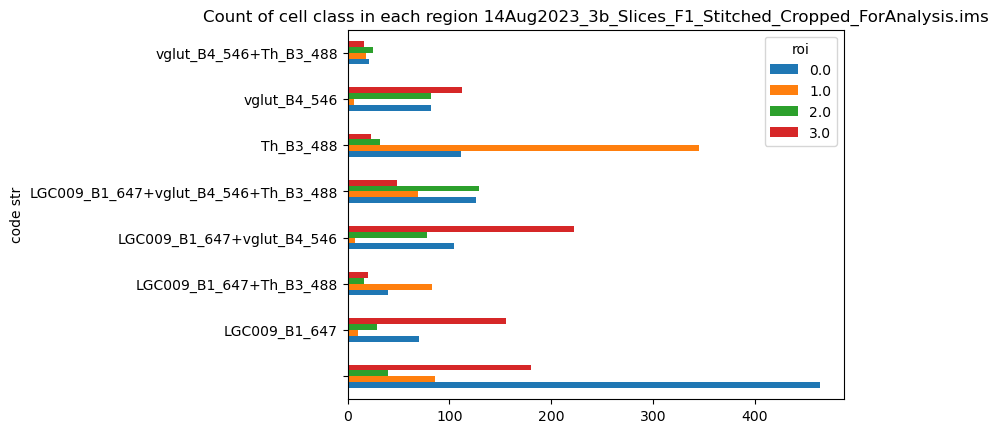

In [16]:
tbl.T.plot(kind='barh')
plt.title(f"Count of cell class in each region {row['name']}");

We can also compute the proportion of cell class in each region:

In [18]:
relative = 100*tbl.div(tbl.sum(axis=1), axis=0)
relative.to_csv(get_files(dstdir, row, 'stats'))
relative

code str,,LGC009_B1_647,LGC009_B1_647+Th_B3_488,LGC009_B1_647+vglut_B4_546,LGC009_B1_647+vglut_B4_546+Th_B3_488,Th_B3_488,vglut_B4_546,vglut_B4_546+Th_B3_488
roi,,,,,,,,
0.0,45.579568,6.876228,3.929273,10.216110,12.377210,10.903733,8.055010,2.062868
1.0,13.782051,1.602564,13.301282,1.121795,11.057692,55.288462,0.961538,2.884615
2.0,9.280742,6.728538,3.712297,18.097448,29.930394,7.424594,19.025522,5.800464
3.0,23.166023,20.077220,2.574003,28.571429,6.177606,2.960103,14.414414,2.059202


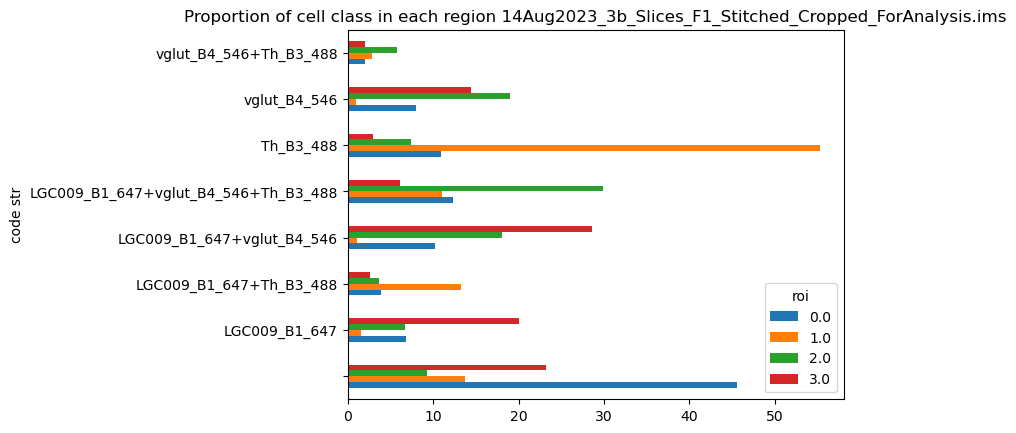

In [19]:
relative.T.plot(kind='barh')
plt.title(f"Proportion of cell class in each region {row['name']}");

## Aggregating cells in sets


In [20]:
tblagg = aggregate_combinations(tbl,{c: tuple(c.split('+')) for c  in tbl.columns} )
tblagg

code str,,LGC009_B1_647,LGC009_B1_647+Th_B3_488,LGC009_B1_647+vglut_B4_546,LGC009_B1_647+vglut_B4_546+Th_B3_488,Th_B3_488,vglut_B4_546,vglut_B4_546+Th_B3_488
roi,,,,,,,,
0.0,464.0,340.0,292.0,356.0,126.0,298.0,333.0,273.0
1.0,86.0,169.0,221.0,145.0,69.0,515.0,100.0,156.0
2.0,40.0,252.0,274.0,336.0,129.0,202.0,314.0,283.0
3.0,180.0,446.0,116.0,318.0,48.0,107.0,398.0,112.0


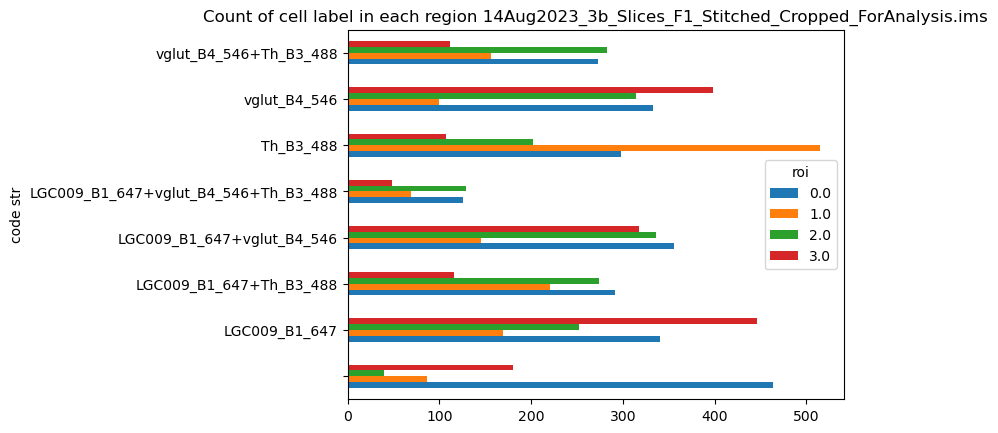

In [21]:
tblagg.T.plot(kind='barh')
plt.title(f"Count of cell label in each region {row['name']}");

We can again compute the proportion of cells in each set. Here the total is still the same as before.

In [22]:
relativeagg = 100*tblagg.div(tbl.sum(axis=1), axis=0)
relative.to_csv(get_files(dstdir, row, 'stats'))
relativeagg

code str,,LGC009_B1_647,LGC009_B1_647+Th_B3_488,LGC009_B1_647+vglut_B4_546,LGC009_B1_647+vglut_B4_546+Th_B3_488,Th_B3_488,vglut_B4_546,vglut_B4_546+Th_B3_488
roi,,,,,,,,
0.0,45.579568,33.398821,28.683694,34.970530,12.377210,29.273084,32.711198,26.817289
1.0,13.782051,27.083333,35.416667,23.237179,11.057692,82.532051,16.025641,25.000000
2.0,9.280742,58.468677,63.573086,77.958237,29.930394,46.867749,72.853828,65.661253
3.0,23.166023,57.400257,14.929215,40.926641,6.177606,13.770914,51.222651,14.414414


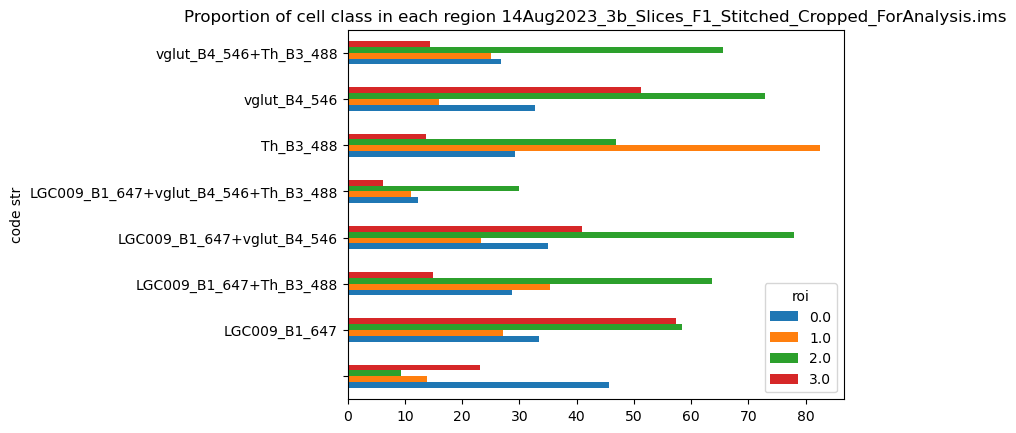

In [23]:
relativeagg.T.plot(kind='barh')
plt.title(f"Proportion of cell class in each region {row['name']}");